In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import tqdm
import sys
import PyComplexHeatmap as pch
import numpy as np
import scipy
import pandas as pd
import anndata

sc.settings.figdir=os.path.expanduser('~/WbFigures/DevAnalysis')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis

import antipode
import antipode.antipode_model
import antipode.model_functions
import antipode.plotting
import antipode.post

from genomics.sc_analysis import corr2_coeff
from os.path import join as pjoin

GPU is not available


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
orthos=pd.read_csv('/home/matthew.schmitz/Matthew/genome/archaic/mm10/HOM_AllOrganism.rpt',sep='\t') #MGI ortholog table for mouse
orthos=orthos.loc[orthos['NCBI Taxon ID'].isin([10090,9606]),:]
classcounts=orthos['DB Class Key'].value_counts()
one2one=classcounts.index[list(classcounts==2)]
orthos=orthos.loc[orthos['DB Class Key'].isin(one2one),:]

htab=orthos.loc[orthos['NCBI Taxon ID']==9606,:]
mtab=orthos.loc[orthos['NCBI Taxon ID']==10090,:]
mdict=dict(zip(mtab['Symbol'],htab['Symbol']))

In [3]:
gl_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists'
hLen=pd.read_csv(pjoin(gl_path,'human_lengths_synteny.txt'),sep='\t',index_col=0)
qLen=pd.read_csv(pjoin(gl_path,'macaque_lengths_synteny.txt'),sep='\t',index_col=0)
mLen=pd.read_csv(pjoin(gl_path,'mouse_lengths_synteny.txt'),sep='\t',index_col=0)


In [4]:
mLen.index=list(mLen['gene'].map(lambda x: mdict.get(x,x)))
qLen.index=list(qLen['gene'])
hLen.index=list(hLen['gene'])
mLen.columns=['m_'+x for x in mLen.columns]
qLen.columns=['q_'+x for x in qLen.columns]
hLen.columns=['h_'+x for x in hLen.columns]


In [5]:
qLen.index=anndata.utils.make_index_unique(qLen.index)
hLen.index=anndata.utils.make_index_unique(hLen.index)
mLen.index=anndata.utils.make_index_unique(mLen.index)

In [6]:
print(mLen)
print(qLen)
print(hLen)

       m_gene  m_gene_size  m_left_flank  m_right_flank  m_syntenic
ATP6     ATP6        680.0           0.0            0.0       False
ATP8     ATP8        203.0           2.0            0.0       False
COX1     COX1       1544.0           2.0            0.0       False
COX2     COX2        683.0           2.0            4.0       False
COX3     COX3        783.0           0.0            1.0       False
...       ...          ...           ...            ...         ...
TrnV     TrnV         68.0           1.0            1.0       False
TrnW     TrnW         66.0           0.0            2.0       False
TrnY     TrnY         66.0           3.0            2.0       False
RNR1-1   RNR1        954.0           2.0            1.0       False
RNR2-1   RNR2       1581.0           1.0            1.0       False

[55523 rows x 5 columns]
                q_gene  q_gene_size  q_left_flank  q_right_flank  q_syntenic
PGBD2            PGBD2       6138.0        7416.0          713.0        True
RNU6

In [7]:
model_tag = '1.9.1.8.5_Dev_final_noQ_INP_moredim_regionsample'
model_path='/home/matthew.schmitz/Matthew/models/'+model_tag
adata=sc.read_h5ad(os.path.join(model_path,'analysis_inprogress.h5ad'))
antipode_model=antipode.antipode_model.ANTIPODE.load(model_path,prefix='p4_',device=device,adata=adata)
adata=antipode_model.adata_manager.adata

INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state

In [8]:
adata

AnnData object with n_obs × n_vars = 1913938 × 16738
    obs: 'G2M_score', 'S_score', 'batch_name', 'general_region', 'log10_n_counts', 'phase', 'region', 'species', 'female', 'general_region_species', '_scvi_discov_ind', '_scvi_batch_ind', 'psi_0', 'psi_1', 'psi_2', 'q_score', 'level_0', 'level_1', 'level_2', 'antipode_cluster', 'kmeans', 'anno_level_2', 'neighborhood', 'curated_class_label', 'doublet', 'individual', 'n_genes', 'percent_ribo', 'msregion', 'dataset_name', 'singlet', 'n_counts', 'timepoint', 'log_abs_sum_dynam', 'clipped_psi_2', 'initial_class', 'ic_extended', 'abc_subclass_markercor', 'juv_subclass_markercor', 'linnarson_extended', 'lamanno_class', 'lamanno_subclass', 'lamanno_cluster', 'new_ccl', 'new_neighborhood', 'ccl_extended', 'new_neighborhood_extended', 'log_n_genes'
    var: 'highly_variable', 'highly_variable_intersection', 'highly_variable_nbatches', 'highly_variable_rank', 'mean', 'means', 'n_cells', 'std', 'variances', 'variances_norm'
    uns: '_scvi_mana

In [9]:
neighborhood_jaccards=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_order_jaccards.csv',index_col=0)
neighborhood_jaccards.columns=['neighborhood_jaccard_'+x for x in neighborhood_jaccards.columns]

In [10]:
batch_key='batch_name'
discov_key='species'
layer_key='spliced'
MDE_KEY = "X_antipode_UMAP"
num_iterations=5000
#gene_lengths
#synteny
#synteny50k

In [11]:
adata.var.loc[qLen.index[qLen.index.isin(adata.var.index)],qLen.columns]=qLen
adata.var.loc[mLen.index[mLen.index.isin(adata.var.index)],mLen.columns]=mLen
adata.var.loc[hLen.index[hLen.index.isin(adata.var.index)],hLen.columns]=hLen
adata.var.loc[neighborhood_jaccards.index[neighborhood_jaccards.index.isin(adata.var.index)],neighborhood_jaccards.columns]=neighborhood_jaccards

In [12]:
adata.var['m_syntenic']=adata.var['m_syntenic'].fillna(False)
adata.var['q_syntenic']=adata.var['q_syntenic'].fillna(False)
adata.var['h_syntenic']=adata.var['h_syntenic'].fillna(False)

/scratch/fast/44751/ipykernel_2373380/3123349924.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.var['m_syntenic']=adata.var['m_syntenic'].fillna(False)
/scratch/fast/44751/ipykernel_2373380/3123349924.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.var['q_syntenic']=adata.var['q_syntenic'].fillna(False)
/scratch/fast/44751/ipykernel_2373380/3123349924.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

In [13]:
#Log10 1p of continuous var covariates
covariates = ['q_gene_size', 'q_left_flank', 'q_right_flank', 'm_gene_size', 'm_left_flank', 'm_right_flank','h_gene_size', 'h_left_flank', 'h_right_flank']
adata.var.loc[:,covariates]=np.log10(1+adata.var.loc[:,covariates])

<Axes: xlabel='h_gene_size', ylabel='Count'>

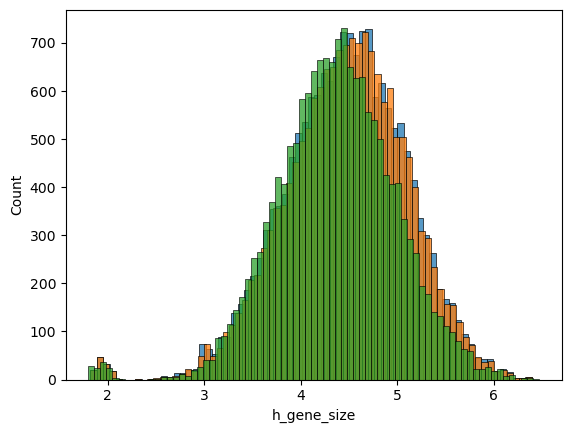

In [14]:
seaborn.histplot(adata.var['h_gene_size'])
seaborn.histplot(adata.var['q_gene_size'])
seaborn.histplot(adata.var['m_gene_size'])

In [15]:
adata.var.to_csv(os.path.join(model_path,'var.csv'))

In [16]:
anndata.settings.allow_write_nullable_strings = True
adata.write_h5ad(os.path.join(model_path,'analysis_inprogress.h5ad'))

In [17]:
adata

AnnData object with n_obs × n_vars = 1913938 × 16738
    obs: 'G2M_score', 'S_score', 'batch_name', 'general_region', 'log10_n_counts', 'phase', 'region', 'species', 'female', 'general_region_species', '_scvi_discov_ind', '_scvi_batch_ind', 'psi_0', 'psi_1', 'psi_2', 'q_score', 'level_0', 'level_1', 'level_2', 'antipode_cluster', 'kmeans', 'anno_level_2', 'neighborhood', 'curated_class_label', 'doublet', 'individual', 'n_genes', 'percent_ribo', 'msregion', 'dataset_name', 'singlet', 'n_counts', 'timepoint', 'log_abs_sum_dynam', 'clipped_psi_2', 'initial_class', 'ic_extended', 'abc_subclass_markercor', 'juv_subclass_markercor', 'linnarson_extended', 'lamanno_class', 'lamanno_subclass', 'lamanno_cluster', 'new_ccl', 'new_neighborhood', 'ccl_extended', 'new_neighborhood_extended', 'log_n_genes'
    var: 'highly_variable', 'highly_variable_intersection', 'highly_variable_nbatches', 'highly_variable_rank', 'mean', 'means', 'n_cells', 'std', 'variances', 'variances_norm', 'q_gene', 'q_gene_s

In [18]:
adsfadf

NameError: name 'adsfadf' is not defined

In [ ]:
species_contrasts=dict(zip(['H/Q','H/M','Q/M'],[[0,1],[0,2],[1,2]]))

q_length_intergenic=pd.read_csv('/mnt/sda/toga_annotations/GeneSizeAndIntergenic_Q.tsv',sep='\t')
h_length_intergenic=pd.read_csv('/mnt/sda/toga_annotations/GeneSizeAndIntergenic_H.tsv',sep='\t')
m_length_intergenic=pd.read_csv('/mnt/sda/toga_annotations/GeneSizeAndIntergenic_M.tsv',sep='\t')

#Intergenic Distance
intergenic_dfs=dict(zip(['human','macaque','mouse'],[h_length_intergenic,q_length_intergenic,m_length_intergenic]))
species_dict=dict(zip(adata.obs.species.cat.categories,list(range(pstore['discov_di'].shape[0]))))
params_dict=dict(zip(['DM','DC','DI','estimated GE'],[dm_diffs,dc_diffs,de_diffs,estimated_ge]))#,'real GE',real_ge

for contrast in species_contrasts.keys():
    fig, ax = plt.subplots(nrows=len(species_dict), ncols=len(params_dict),figsize=(30,30))
    for i,species in enumerate(species_dict.keys()):
        species_ind=species_dict[species]
        for j,paramname in enumerate(params_dict.keys()):
            if species not in intergenic_dfs.keys():
                continue
            params=params_dict[paramname]
            idf=intergenic_dfs[species]
            idf=idf.loc[(idf.loc[:,'left_flank']+idf.loc[:,'right_flank'])>0,:]
            param_contrast=params[species_contrasts[contrast][0]]-params[species_contrasts[contrast][1]]
            adata_genes=adata.var.index.isin(idf['gene'])
            genes=adata.var.index[adata_genes]
            idf.index=idf['gene']
            idf=idf.loc[genes,:]
            x=np.log10(idf.loc[:,'left_flank']+idf.loc[:,'right_flank']+1)
            #x=np.log10(idf.loc[:,['left_flank','right_flank']].min(1)+1)
            y=param_contrast[:,adata_genes].var(0)
            pval=resampling_slope_p_value(x.to_numpy(),y, num_iterations=num_iterations)

            #y=np.abs(param_contrast[:,adata_genes]).max(0)[0]
            seaborn.scatterplot(x,y,color='black',ax=ax[i][j],alpha=0.1,legend=None)        
            a, b = np.polyfit(x, y, 1)
            model=np.poly1d([a,b])
            ax[i][j].plot(x, a*x+b)
            ax[i][j].set_xlim((0,x.max()))
            ax[i][j].set_ylim((0,y.max()))
            r2=sklearn.metrics.r2_score(y,model(x))
            #seaborn.regplot((idf.loc[:,'left_flank']+idf.loc[:,'right_flank']+1),param_contrast[:,adata_genes].var(0).flatten(),color='black',ax=ax[i][j])        
            ax[i][j].set_title(paramname+" Distances in "+species+'\n'+
                               'm='+'%.2E'%Decimal(a)+', b='+'%.2E'%Decimal(b)+', r^2='+'%.2E'%Decimal(r2)+'\n'+
                                'resampled pval='+'%.2E'%Decimal(str(pval)),
                               y=1
                              )
            #ax[i][j].set_title('in median ='+str(np.median(comparison[:,gidx]))+'\nout median ='+str(np.median(comparison[:,ngidx])),y=0.8, fontsize=10)
    fig.suptitle('Log10 Intergenic Distance (x) vs '+contrast+' Var Parameter (y)',y=0.93,fontsize=18)
    plt.show(fig)

In [ ]:
kmeans_means=pstore['locs'][-antipode_model.level_sizes[-1]:,:]
hierarchy=scipy.cluster.hierarchy.ward(kmeans_means)
level_assignments=[scipy.cluster.hierarchy.cut_tree(hierarchy,n_clusters=x) for x in antipode_model.level_sizes]
adj_means_dict=calculate_layered_tree_means(kmeans_means, level_assignments)
new_clusts=[adj_means_dict[k][j] for k in adj_means_dict.keys() for j in adj_means_dict[k].keys()]
new_locs=np.array(new_clusts)

In [ ]:
#A layered tree, each cluster has membership in one cluster at each level. The output mean is the sum of the means at each level
#The goal is to find the most efficient allocation of parameters (minimize output_mean_matrix.sum())
#number of nodes at each level of the layered tree
level_sizes=[1,3,5]
latent_dim=11
level_assignments=[[0,0,0,0,0],[0,0,1,2,0],[0,1,2,3,4]]
#Represents the mean of the leaf node clusters
X=np.random.standard_normal([level_sizes[-1],latent_dim])

#output should be [sum(layer_sizes),11]
#Find the cluster means output_mean_matrix

In [ ]:
def calculate_cluster_means(level_sizes, latent_dim, level_assignments, X):
    # Prepare the output matrix, filled initially with zeros
    total_nodes = sum(level_sizes)
    output_mean_matrix = np.zeros((total_nodes, latent_dim))

    # Start filling the output from the bottom layer, which are the leaf nodes
    current_start_index = total_nodes - level_sizes[-1]
    output_mean_matrix[current_start_index:] = X

    # Iterate through each level (except the leaf nodes) to calculate the means
    for level_index in range(len(level_sizes) - 2, -1, -1):
        level_size = level_sizes[level_index]
        child_level_size = level_sizes[level_index + 1]
        child_level_start_index = current_start_index
        current_start_index -= level_size

        for cluster_index in range(level_size):
            child_indices = [i for i, x in enumerate(level_assignments[level_index]) if x == cluster_index]
            # Calculate the mean for this cluster as the sum of its children's means at the next level
            if child_indices:  # Check if the cluster has any children
                cluster_mean = np.mean(output_mean_matrix[child_level_start_index + np.array(child_indices)], axis=0)
            else:
                # If no children, this should not happen based on our setup, but we'll handle it just in case
                cluster_mean = np.zeros(latent_dim)
            output_mean_matrix[current_start_index + cluster_index] = cluster_mean

    return output_mean_matrix

In [ ]:
def calculate_cluster_means_inferred(X,level_assignments):
    # Infer latent dimension from X
    latent_dim = X.shape[1]
    # Infer level sizes from level_assignments and X
    level_sizes = [len(np.unique(level)) for level in level_assignments]
    level_sizes.append(X.shape[0])  # Add the leaf level size
    
    # Prepare the output matrix
    total_nodes = sum(level_sizes)
    output_mean_matrix = np.zeros((total_nodes, latent_dim))
    
    # Start from the leaf nodes
    current_start_index = total_nodes - level_sizes[-1]
    output_mean_matrix[current_start_index:] = X

    # Iterate through each level (except the leaf nodes)
    for level_index in range(len(level_sizes) - 2, -1, -1):
        level_size = level_sizes[level_index]
        child_level_size = level_sizes[level_index + 1]
        child_level_start_index = current_start_index
        current_start_index -= level_size

        for cluster_index in range(level_size):
            child_indices = [i for i, x in enumerate(level_assignments[level_index]) if x == cluster_index]
            if child_indices:  # If the cluster has children
                cluster_mean = np.mean(output_mean_matrix[child_level_start_index + np.array(child_indices)], axis=0)
            else:  # In case of no children (shouldn't happen in this setup)
                cluster_mean = np.zeros(latent_dim)
            output_mean_matrix[current_start_index + cluster_index] = cluster_mean

    return output_mean_matrix

# Run the revised function without requiring explicit level_sizes and latent_dim
output_mean_matrix_inferred = calculate_cluster_means_inferred(X,level_assignments)
seaborn.clustermap(output_mean_matrix_inferred)

In [ ]:
def calculate_layered_tree_means(X, level_assignments):
    leaf_means=[X[np.where(level_assignments[-1]==c)[1]].mean() for c in sorted(np.unique(level_assignments[-1]))]
    outs=[]
    for i,a in enumerate(level_assignments):
        for c in sorted(np.unique(a)):
            print(c,np.where(level_assignments==c)[1])


In [ ]:
hierarchy=scipy.cluster.hierarchy.ward(kmeans_means)
level_assignments=[scipy.cluster.hierarchy.cut_tree(hierarchy,n_clusters=x) for x in antipode_model.level_sizes]
#seaborn.clustermap(calculate_cluster_means_inferred(kmeans_means, level_assignments),cmap='coolwarm')
seaborn.heatmap(calculate_cluster_means(antipode_model.level_sizes, antipode_model.num_latent, level_assignments, kmeans_means),cmap='coolwarm')

In [ ]:

def calculate_layered_tree_means(X, level_assignments):
    means = {}
    adjusted_means = {}
    cumulative_adjustments = np.zeros_like(X[0])
    
    for level, assignments in enumerate(level_assignments, start=1):
        unique_clusters = np.unique(assignments)
        level_mean_adjustments = np.zeros_like(X[0])
        
        # Calculate the initial means for each cluster at the current level
        means[level] = {}
        for cluster in sorted(unique_clusters):
            cluster_mean = X[assignments.flatten() == cluster].mean(axis=0)
            means[level][cluster] = cluster_mean
            
            # Apply adjustments from previous levels
            adjusted_cluster_mean = cluster_mean - cumulative_adjustments
            adjusted_means.setdefault(level, {})[cluster] = adjusted_cluster_mean
            
            # Accumulate adjustments for the current level
            level_mean_adjustments += adjusted_cluster_mean
        
        # Update cumulative adjustments for the next level
        num_clusters = len(unique_clusters)
        if num_clusters > 0:  # Avoid division by zero
            cumulative_adjustments += level_mean_adjustments / num_clusters

    return adjusted_means


hierarchy=scipy.cluster.hierarchy.ward(kmeans_means)
level_assignments=[scipy.cluster.hierarchy.cut_tree(hierarchy,n_clusters=x) for x in antipode_model.level_sizes]
adj_means_dict=calculate_layered_tree_means(kmeans_means, level_assignments)
new_clusts=[adj_means_dict[k][j] for k in adj_means_dict.keys() for j in adj_means_dict[k].keys()]
seaborn.clustermap(np.array(new_clusts),cmap='coolwarm')

In [ ]:
seaborn.clustermap(kmeans_means-kmeans_means.mean(0,keepdims=True))

In [ ]:
seaborn.histplot(adj_means_dict[1][0]+adj_means_dict[2][0]+adj_means_dict[3][0])

In [ ]:
seaborn.histplot(kmeans_means.flatten())